In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal
import scipy.linalg as la
import scipy.stats as sts
from matplotlib.pyplot import *

import jax
import jax.numpy as jnp

from copy import copy

In [2]:
%matplotlib widget

I0000 00:00:1704390057.815978       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Text(0, 0.5, 'Cross Section')

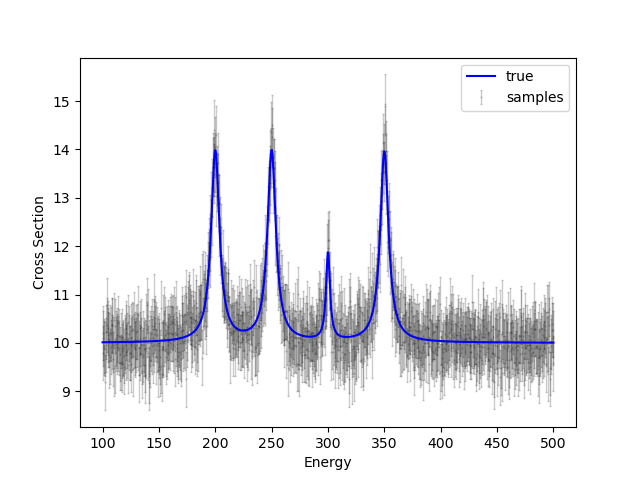

In [3]:
# Define the function using JAX NumPy
def Breit_Wigner(theta, E):
    Elam, Gg, Gn = jnp.split(theta, 3)
    xs = jnp.zeros(len(E))
    for iE, iGg, iGn in zip(Elam, Gg, Gn):
        xs += iGg * iGn / ((E - iE) ** 2 + (iGg + iGn) ** 2 / 4)
    return xs*10 + 10


idat = 1000
E = np.linspace(100,500,idat)


true_theta = np.array([200.0,250.0,300.0,350.0,
                       8.0,8.0,4.0,8.0,
                        1.0,1.0,0.2,1.0])
true_mod = Breit_Wigner(true_theta, E)
std = np.sqrt(true_mod)/10
sample_data = sts.norm.rvs(loc=true_mod, scale=std)
sample_cov = np.diag(np.ones(len(sample_data))*std)

# ifb = 10
# prior_theta = np.concatenate([np.linspace(10,100,ifb), np.ones(ifb)*8.0, np.ones(ifb)*4.0])
# prior_cov= np.diag(np.ones(ifb*2)*100)
# prior_mod = Breit_Wigner(prior_theta,E)

figure()
# plot(x, lorentz(x, 50, 10))
errorbar(E, sample_data, yerr=np.sqrt(np.diag(sample_cov)).flatten(),
          alpha=0.2, fmt='.', capsize=1, markersize=1, linewidth=1, color='k', label='samples')
plot(E, true_mod, label='true', color='b')
# plot(E, prior_mod, label='prior')

legend()
xlabel('Energy')
ylabel('Cross Section')

In [4]:
# def sensitivity(theta):

#     Elam = theta.reshape((3, -1))[0,:]
#     Gg = theta.reshape((3, -1))[1,:]
#     Gn = theta.reshape((3, -1))[2,:]
#     sensE = np.zeros((len(E), len(Elam)))
#     sensG = np.zeros((len(E), len(G)))

#     for i, (iE, iGg, iGn) in enumerate(zip(Elam, Gg, Gn)):
#         df_dG = (E-iE)/(E-iE + iG)**2
#         df_dE = iG/(E-iE + iG)**2
#         sensE[:, i] = df_dE
#         sensG[:, i] = df_dG

#     return np.hstack([sensE, sensG])


# Compute the gradient with respect to each element of theta using JAX
# grad_theta = jax.jacobian(Breit_Wigner, argnums=0)(true_theta, E)
# print("Gradient with respect to theta:", grad_theta)

def plotit(prior_theta, post_theta):
    Elam, Gg, Gn = jnp.split(prior_theta, 3)
    Elam_p, Gg_p, Gn_p = jnp.split(post_theta, 3)

    print(np.count_nonzero(Gn>1e-2))
    print(np.count_nonzero(Gn_p>1e-2))

    fig,axes = subplots(1,2,figsize=(12,4))

    # plot(x, lorentz(x, 50, 10))
    axes[0].plot(E, true_mod, label='true')
    axes[0].errorbar(E, sample_data, yerr=np.sqrt(np.diag(sample_cov)).flatten(), 
            alpha=0.2, fmt='.', capsize=1, markersize=1, linewidth=1, color='k', label='samples')

    axes[0].plot(E, Breit_Wigner(prior_theta,E),lw=2, label='prior', color='orange')

    axes[0].plot(E, Breit_Wigner(post_theta, E), label='post', color='r')

    # for itheta in theta_log2:
    #     post_mod = Breit_Wigner(itheta, E)
    #     axes[0].plot(E, post_mod)

    axes[0].legend()

    bins=axes[1].hist(np.log10(Gn), density=True, bins=50, color='orange', label="prior")
    bins=axes[1].hist(np.log10(Gn_p), density=True, bins=50, alpha=0.5, color='r', label="post")

    return fig



def descend(theta, alpha, iterations=200, lambda_lasso=0.0, thresh=1e0, print_bool=False, adaptive=True, weights=None):
    saved_thetas = []
    chi2_log = []
    for i in range(iterations):

        # Compute predictions
        y_pred = Breit_Wigner(theta, E)
        chi2 = (sample_data-y_pred).T @ la.inv(sample_cov) @ (sample_data-y_pred)
        chi2_log.append(chi2.item())
        if print_bool:
            print(chi2)
        
        if i > 1:
            if abs(chi2_log[i-1]-chi2_log[i]) < thresh:
                print("Converged")
                break
        
        # Compute the gradient of the mean squared error with L1 penalty
        G = jax.jacobian(Breit_Wigner, argnums=0)(theta, E)
        Elam, Gg, Gn = jnp.split(theta, 3)
        lasso = np.concatenate([np.zeros_like(Elam), 
                                # lambda_lasso*np.sign(Gg),
                                np.zeros_like(Gg),
                                lambda_lasso*np.sign(Gn)])
        # OLS = la.inv(G.T@G)@G.T@sample_data
        # OLS = np.concatenate([np.ones_like(Elam),np.ones_like(Gg), Gn])
        if adaptive:
            if weights is None:
                # weights =np.ones(len(lasso))
                weights = np.concatenate([np.ones_like(Elam),np.ones_like(Gg), Breit_Wigner(theta,Elam)])
                # weights = np.concatenate([np.ones_like(Elam),np.ones_like(Gg), (2*np.sqrt(abs(Gn)))])
            lasso = lasso/weights
        
        gradient = -(G.T@la.inv(sample_cov)@(sample_data-y_pred) - lasso)  / len(y_pred)
        
        # Update coefficients using gradient descent
        saved_thetas.append(copy(theta))
        theta -= alpha * gradient

    return saved_thetas, chi2_log



In [5]:
ifb = 100
prior_theta = np.concatenate([np.linspace(min(E),max(E),ifb),# np.array([210.0,240.0,220.0, 225.0, 245.0])
                              np.ones(ifb)*4.0, 
                              np.ones(ifb)*1.0])

# theta = copy(prior_theta)

# Learning rate and number of iterations
alpha = 0.1
alpha = np.concatenate([np.ones(ifb)*alpha, np.ones(ifb)*0, np.ones(ifb)*alpha])

theta_log, chi2_log = descend(copy(prior_theta), alpha, iterations=200, lambda_lasso=10.0, thresh=1e0, print_bool=True, adaptive=False)

432556.62
201345.73
66665.21
14861.717
2921.7512
1065.1694
741.8129
632.63696
573.86786
534.60077
505.65762
482.98453
464.586
449.1427
436.0654
424.8468
415.12326
406.6147
399.14365
392.60672
386.86627
381.7513
377.31454
373.4351
369.99377
366.9703
364.23242
362.0091
360.0521
358.30533
356.77408
355.41147
354.25446
353.31607
Converged


In [6]:
# chi2_log
# print(true_theta)
# print(theta)

print(f"True Chi2: {(sample_data-Breit_Wigner(true_theta,E)).T @ la.inv(sample_cov) @ (sample_data-Breit_Wigner(true_theta,E))}")
print(f"Est Chi2: {chi2_log[-1]}")

# print(f"True theta: {true_theta}")
# print(f"Est theta: {theta}")

True Chi2: 353.4160461425781
Est Chi2: 353.3160705566406


/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_75991/2917676315.py:17: RuntimeWarning: invalid value encountered in log10
  bins=axes[1].hist(np.log10(Gn), density=True, bins=50)


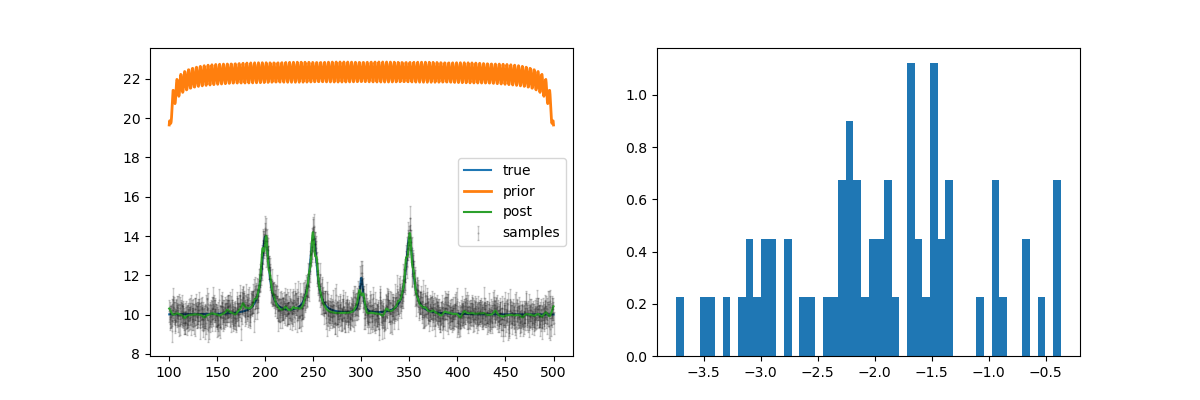

In [7]:
Elam, Gg, Gn = jnp.split(theta_log[-1], 3)


fig,axes = subplots(1,2,figsize=(12,4))

# plot(x, lorentz(x, 50, 10))
axes[0].plot(E, true_mod, label='true')
axes[0].errorbar(E, sample_data, yerr=np.sqrt(np.diag(sample_cov)).flatten(), 
          alpha=0.2, fmt='.', capsize=1, markersize=1, linewidth=1, color='k', label='samples')

axes[0].plot(E, Breit_Wigner(prior_theta,E),lw=2, label='prior')

post_mod = Breit_Wigner(theta_log[-1], E)
axes[0].plot(E, post_mod, label='post')
axes[0].legend()

bins=axes[1].hist(np.log10(Gn), density=True, bins=50)

In [10]:
sample_data.shape

(1000,)

In [8]:
alpha = 0.01
alpha = np.concatenate([np.ones(ifb)*alpha, np.ones(ifb)*alpha, np.ones(ifb)*alpha])

# theta_log2, chi2_log2 = descend(copy(theta_log[-1]), alpha, iterations=200, lambda_lasso=100.0, thresh=1e0, print_bool=False, adaptive=False)

lasso = []
ll = 10
sumGn = np.sum(Gn)
while sumGn > 0.3:
    theta_log2, chi2_log2 = descend(copy(theta_log[-1]), alpha, iterations=200, lambda_lasso=ll, thresh=1e0, print_bool=False, adaptive=False)
    lasso.append(theta_log2[-1])
    Elam, Gg, Gn = jnp.split(theta_log2[-1], 3)
    sumGn = np.sum(Gn)
    ll += 50

Converged
Converged


Could try some transform on the lasso parameters to penalize more based on cardinality rather than magnitude of parameters

In [ ]:
# jnp.split(theta_log2[-1], 3)
Elam, Gg, Gn= jnp.split(theta_log[-1], 3)
weights = Breit_Wigner(theta_log[-1],Elam)

alpha = 0.01
alpha = np.concatenate([np.ones(ifb)*alpha, np.ones(ifb)*alpha, np.ones(ifb)*alpha])

# theta_log2a, chi2_log2a = descend(copy(theta_log[-1]), alpha, iterations=200, lambda_lasso=2000.0, thresh=1e0, print_bool=True, adaptive=True, weights=None) #weights=np.concatenate([np.ones_like(Elam),np.ones_like(Gg), weights]))

# lasso_adapt = []
# ll = 5150
# sumGn = np.sum(Gn)
while sumGn > 0.3:
    theta_log2a, chi2_log2a = descend(copy(theta_log[-1]), alpha, iterations=200, lambda_lasso=ll, thresh=1e0, print_bool=False, adaptive=True, weights=None) #weights=np.concatenate([np.ones_like(Elam),np.ones_like(Gg), weights]))
    lasso_adapt.append(theta_log2a[-1])
    Elam, Gg, Gn = jnp.split(theta_log2a[-1], 3)
    sumGn = np.sum(Gn)
    print(sumGn)
    ll += 1000

Converged
0.99543405
Converged
0.9683858
Converged
0.4871698
Converged
1.2059253


KeyboardInterrupt: 

In [ ]:
print(sumGn)

Array(1.9373379, dtype=float32)

44
10


/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_22278/2136421182.py:46: RuntimeWarning: invalid value encountered in log10
  bins=axes[1].hist(np.log10(Gn), density=True, bins=50, color='orange', label="prior")
/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_22278/2136421182.py:47: RuntimeWarning: invalid value encountered in log10
  bins=axes[1].hist(np.log10(Gn_p), density=True, bins=50, alpha=0.5, color='r', label="post")
/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_22278/2473152328.py:7: RuntimeWarning: invalid value encountered in log10
  axes[1].hist(np.log10(Gna), label="adaptive", color='g', alpha=0.5, density=True, bins=50)


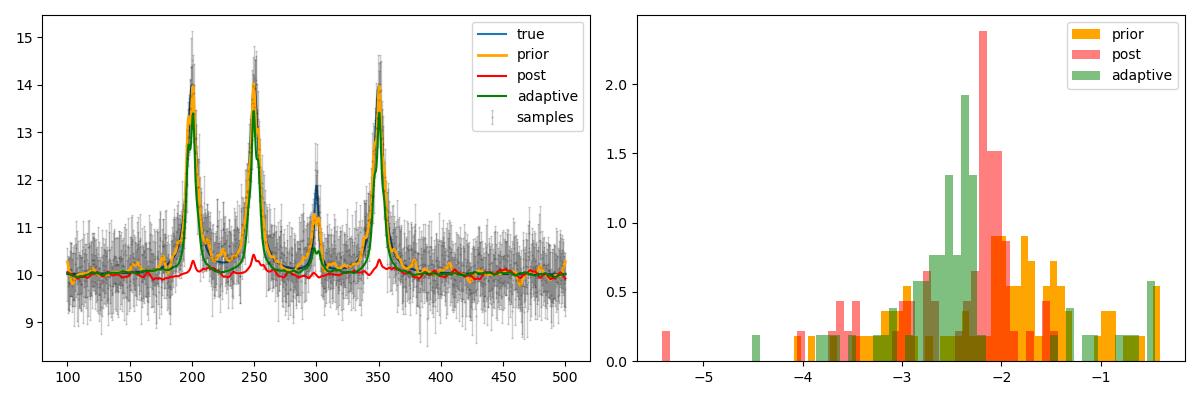

In [ ]:
fig = plotit(theta_log[-1], theta_log2[-1])
axes = fig.get_axes()

axes[0].plot(E, Breit_Wigner(theta_log2a[-1],E), label="adaptive", color='g')

Elama, Gga, Gna = jnp.split(theta_log2a[-1], 3)
axes[1].hist(np.log10(Gna), label="adaptive", color='g', alpha=0.5, density=True, bins=50)

fig.tight_layout()
axes[0].legend()
axes[1].legend()

In [ ]:
len(lasso_adapt)
103*50

5150

In [ ]:
import imageio.v3 as iio

# for i, each in enumerate(lasso):

#     fig = plotit(theta_log[-1], each)

#     axes = fig.get_axes()
#     # axes[0].plot(E, Breit_Wigner(theta_log2a[i],E), label="adaptive", color='g')
#     # Elama, Gga, Gna = jnp.split(theta_log2a[i], 3)
#     # axes[1].hist(np.log10(Gna), label="adaptive", color='g', alpha=0.5, density=True, bins=50)
#     axes[1].set_xlim([-5,0])
#     # fig.tight_layout()
#     # axes[0].legend()
#     # axes[1].legend()
#     fig.savefig(f"./figures/{i}.png")
#     close()



# for i, each in enumerate(lasso_adapt):
#     fig = plotit(theta_log[-1], each);
#     axes = fig.get_axes()
#     axes[1].set_xlim([-5,0])
#     fig.savefig(f"./figures/adapt{i}.png")
#     close()

In [ ]:
import imageio


images = []
for i in range(22):
    images.append(iio.imread(f"./figures/{i}.png"))
# iio.imwrite(f"lasso.gif", images, { 'duration': 5 })
imageio.mimsave("lasso.gif", images, duration=10.0)

images = []
for i in range(123):
    images.append(iio.imread(f"./figures/adapt{i}.png"))
# iio.imwrite(f"lasso.gif", images, { 'duration': 5 })
imageio.mimsave("adaptive_lasso.gif", images, duration=10.0)

In [ ]:

images = []
for i, each in enumerate(lasso):
    images.append(iio.imread(f"./figures/{i}.png"))
# iio.imwrite(f"lasso.gif", images, { 'duration': 5 })
imageio.mimsave("lasso.gif", images, duration=5.0)

images = []
for i, each in enumerate(lasso_adapt):
    images.append(iio.imread(f"./figures/adapt{i}.png"))
# iio.imwrite(f"lasso.gif", images, { 'duration': 5 })
imageio.mimsave("adaptive_lasso.gif", images, duration=5.0)

NameError: name 'lasso' is not defined